In [1]:
import pandas as pd
import datetime
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [2]:
df = pd.read_csv("m5-forecasting-accuracy/sales_train_validation.csv").head(100)
df["id"] = df["item_id"] + "_" + df["store_id"]
df = df[["id", ] + [cn for cn in df.columns if cn.startswith("d_")]]

df = df.melt(id_vars="id", var_name="timestamp", value_name="value")
df["timestamp"] = pd.to_datetime(df["timestamp"].apply(lambda x: datetime.datetime(2011,1,28) + datetime.timedelta(days=int(str(x).replace("d_", "")))))

train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="id",
    timestamp_column="timestamp"
)
train_data.head()

,,value
item_id,timestamp,
HOBBIES_1_001_CA_1,2011-01-29,0
HOBBIES_1_002_CA_1,2011-01-29,0
HOBBIES_1_003_CA_1,2011-01-29,0
HOBBIES_1_004_CA_1,2011-01-29,0
HOBBIES_1_005_CA_1,2011-01-29,0


In [3]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    path="autogluon-m5-daily",
    target="value",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/home/rsmith/PycharmProjects/time-series-llm/autogluon-m5-daily'
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Dec 13 05:06:24 UTC 2025
CPU Count:          8
Pytorch Version:    2.7.1+cu118
CUDA Version:       11.8
GPU Memory:         GPU 0: 1.96/1.96 GB
Total GPU Memory:   Free: 1.96 GB, Allocated: 0.00 GB, Total: 1.96 GB
GPU Count:          1
Memory Avail:       7.89 GB / 15.47 GB (51.0%)
Disk Space Avail:   360.39 GB / 474.34 GB (76.0%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 'auto',
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'ref

In [4]:
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-1.272758,11.291167,3.202439,10
1,Chronos2,-1.273062,6.537949,16.599245,5
2,TemporalFusionTransformer,-1.283797,0.258746,142.247868,8
3,DeepAR,-1.283936,2.358118,145.042213,9
4,ChronosWithRegressor[bolt_small],-1.285697,2.116935,2.471948,7
5,DirectTabular,-1.472750,0.855644,5.990320,3
6,AutoETS,-1.531351,13.724999,12.629222,6
7,DynamicOptimizedTheta,-1.536329,20.311875,16.543194,4
8,SeasonalNaive,-1.700216,0.222782,4.529965,1
9,RecursiveTabular,-1.728235,0.781819,42.008143,2


In [5]:
predictions = predictor.predict(train_data, prediction_length=28)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean       0.1       0.2       0.3  \
item_id            timestamp                                            
HOBBIES_1_001_CA_1 2016-04-25  0.257769 -0.095540 -0.002812  0.052530   
                   2016-04-26  0.289052 -0.079568  0.015053  0.064052   
                   2016-04-27  0.274889 -0.081718 -0.006535  0.046710   
                   2016-04-28  0.242367 -0.117518 -0.031224  0.036680   
                   2016-04-29  0.298391 -0.066277  0.006446  0.050363   

                                    0.4       0.5       0.6       0.7  \
item_id            timestamp                                            
HOBBIES_1_001_CA_1 2016-04-25  0.122459  0.257769  0.764474  1.258396   
                   2016-04-26  0.135640  0.289052  0.814921  1.289261   
                   2016-04-27  0.111469  0.274889  0.803554  1.293380   
                   2016-04-28  0.095711  0.242367  0.754054  1.213844   
                   2016-04-29  0.118931  0.298391  0.802556  1.260023   

                                    0.8       0.9  
item_id            timestamp                       
HOBBIES_1_001_CA_1 2016-04-25  1.727131  2.356940  
                   2016-04-26  1.757675  2.385206  
                   2016-04-27  1.752022  2.399210  
                   2016-04-28  1.688092  2.334364  
                   2016-04-29  1.753210  2.423368

In [6]:
test_df = pd.read_csv("m5-forecasting-accuracy/sales_train_evaluation.csv")
test_df["id"] = test_df["item_id"] + "_" + test_df["store_id"]
test_df = test_df[test_df["id"].isin(df["id"].unique())]
test_df = test_df[["id", ] + [cn for cn in test_df.columns if cn.startswith("d_")]].melt(id_vars="id", var_name="timestamp", value_name="value")
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"].apply(lambda x: datetime.datetime(2011,1,28) + datetime.timedelta(days=int(str(x).replace("d_", "")))))

test_data = TimeSeriesDataFrame.from_data_frame(
    test_df,
    id_column="id",
    timestamp_column="timestamp"
)
test_data

,,value
item_id,timestamp,
HOBBIES_1_001_CA_1,2011-01-29,0
HOBBIES_1_002_CA_1,2011-01-29,0
HOBBIES_1_003_CA_1,2011-01-29,0
HOBBIES_1_004_CA_1,2011-01-29,0
HOBBIES_1_005_CA_1,2011-01-29,0
...,...,...
HOBBIES_1_099_CA_1,2016-05-22,2
HOBBIES_1_100_CA_1,2016-05-22,0
HOBBIES_1_102_CA_1,2016-05-22,0


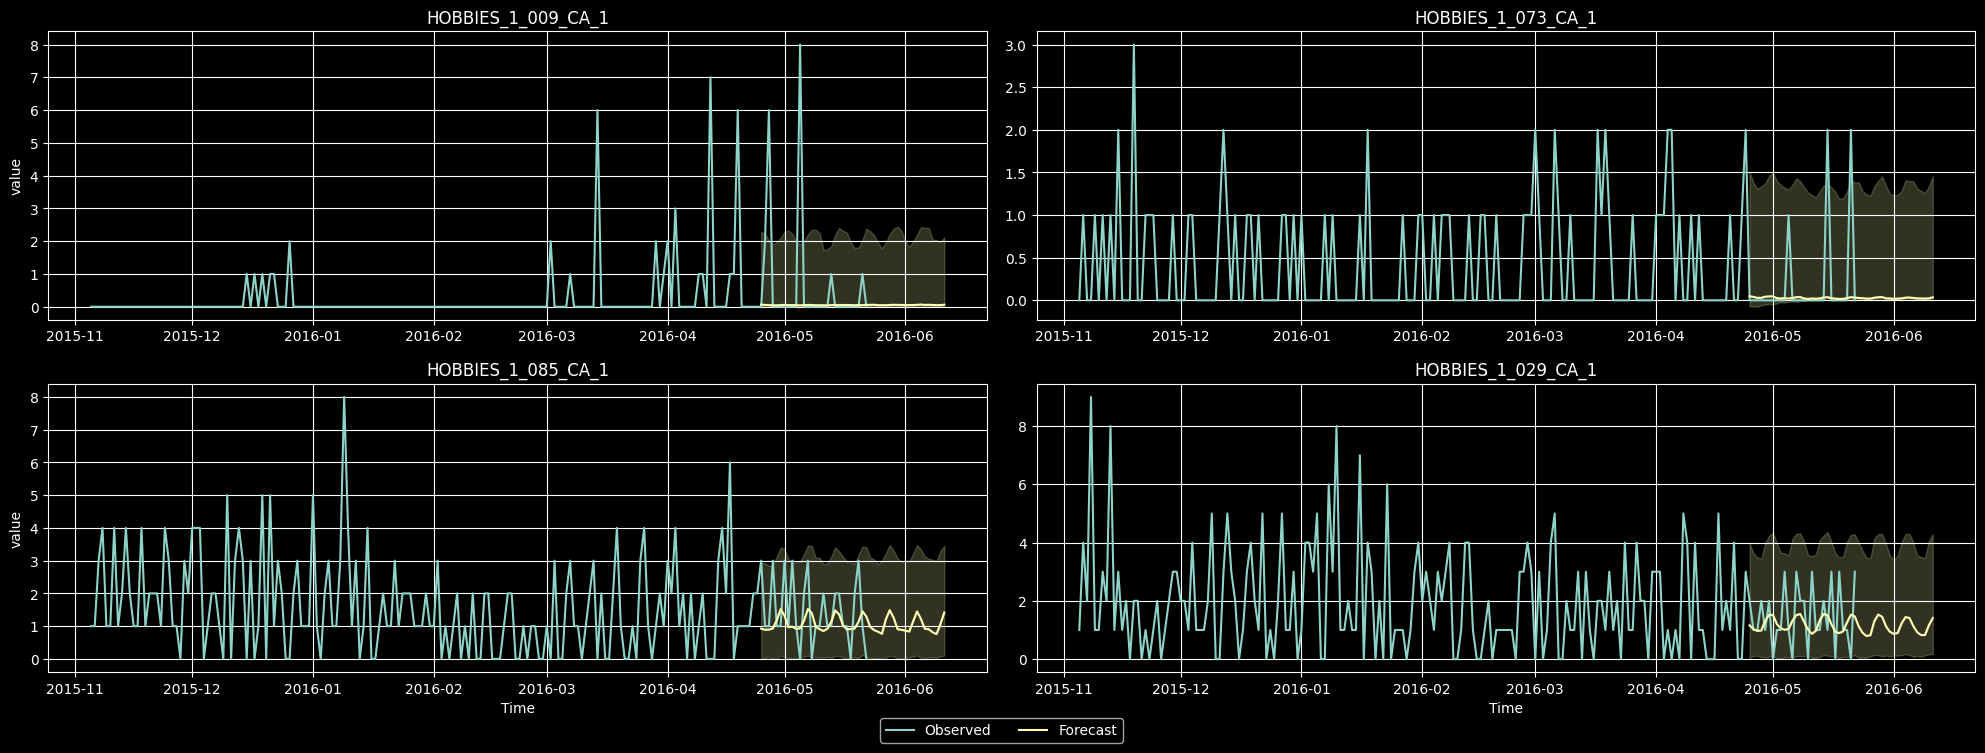

In [7]:
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4);